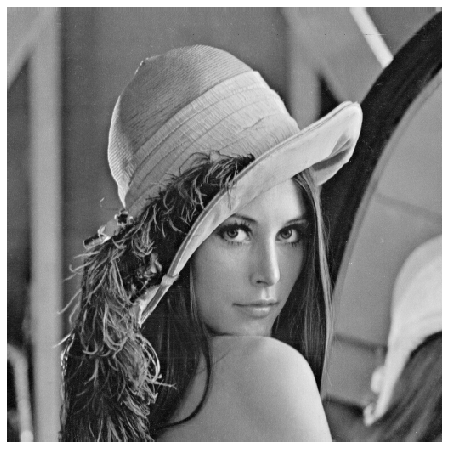

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
plt.rcParams['figure.figsize'] = [16,8]

A = imread('lena.png')
X = np.mean(A, -1)
# X = X[400:500,400:500]

img = plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()

In [12]:
def svd_simultaneous_power_iteration(A, k, epsilon=0.00001):
    #source http://mlwiki.org/index.php/Power_Iteration
    #adjusted to work with n<m and n>m matrices
    n_orig, m_orig = A.shape
    if k is None:
        k=min(n_orig,m_orig)
    A_orig=A.copy()
    if n_orig > m_orig:
        A = A.T @ A
        n, m = A.shape
    elif n_orig < m_orig:
        A = A @ A.T
        n, m = A.shape
    else:
        n,m=n_orig, m_orig
        
    Q = np.random.rand(n, k)
    Q, _ = np.linalg.qr(Q)
    Q_prev = Q
    #this part does the block power iteration
    for i in range(10000):
        Z = A @ Q
        Q, R = np.linalg.qr(Z)
        err = ((Q - Q_prev) ** 2).sum()
        Q_prev = Q
        if err < epsilon:
            break
            
    singular_values=np.sqrt(abs(np.diag(R))) 
    #deal with different shape input matrices
    if n_orig < m_orig: 
        left_vecs=Q.T
        #use property Values @ V = U.T@A => V=inv(Values)@U.T@A
        right_vecs=np.linalg.inv(np.diag(singular_values))@left_vecs.T@A_orig
    elif n_orig==m_orig:
        left_vecs=Q.T
        right_vecs=left_vecs
        singular_values=np.square(singular_values)
    else:
        right_vecs=Q.T
        #use property Values @ V = U.T@A => U=A@V@inv(Values)
        left_vecs=A_orig@ right_vecs.T @np.linalg.inv(np.diag(singular_values))

    return singular_values, left_vecs.T, right_vecs

In [10]:
import numpy as np
from numpy.linalg import norm

from random import normalvariate
from math import sqrt


def randomUnitVector(n):
    unnormalized = [normalvariate(0, 1) for _ in range(n)]
    theNorm = sqrt(sum(x * x for x in unnormalized))
    return [x / theNorm for x in unnormalized]


def svd_1d(A, epsilon=1e-10):
    ''' The one-dimensional SVD '''

    n, m = A.shape
    x = randomUnitVector(min(n,m))
    lastV = None
    currentV = x

    if n > m:
        B = np.dot(A.T, A)
    else:
        B = np.dot(A, A.T)

    iterations = 0
    while True:
        iterations += 1
        lastV = currentV
        currentV = np.dot(B, lastV)
        currentV = currentV / norm(currentV)

        if abs(np.dot(currentV, lastV)) > 1 - epsilon:
#             print("converged in {} iterations!".format(iterations))
            return currentV


def svd(A, k=None, epsilon=1e-10):
    '''
        Compute the singular value decomposition of a matrix A
        using the power method. A is the input matrix, and k
        is the number of singular values you wish to compute.
        If k is None, this computes the full-rank decomposition.
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    svdSoFar = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrixFor1D = A.copy()

        for singularValue, u, v in svdSoFar[:i]:
            matrixFor1D -= singularValue * np.outer(u, v)

        if n > m:
            v = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            u_unnormalized = np.dot(A, v)
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            v_unnormalized = np.dot(A.T, u)
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svdSoFar.append((sigma, u, v))

    singularValues, us, vs = [np.array(x) for x in zip(*svdSoFar)]
    return singularValues, us.T, vs


[[-0.04779008 -0.00338482 -0.03488352 ...  0.03254559 -0.00674829
   0.03602599]
 [-0.04779008 -0.00338482 -0.03488352 ...  0.03254559 -0.00674829
   0.03602599]
 [-0.04779008 -0.00338482 -0.03488352 ...  0.03254559 -0.00674829
   0.03602599]
 ...
 [-0.04170422  0.06594411  0.03461313 ...  0.0340686   0.05185705
  -0.08430624]
 [-0.04177322  0.06664681  0.03587849 ...  0.04078832  0.04440058
  -0.06156139]
 [-0.04177322  0.06664681  0.03587849 ...  0.04078832  0.04440058
  -0.06156139]]
[[256.42053016   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          28.25857143   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0

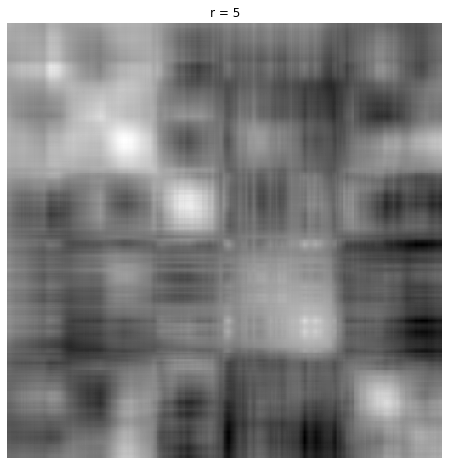

(512, 20)
(20, 20)
(20, 512)


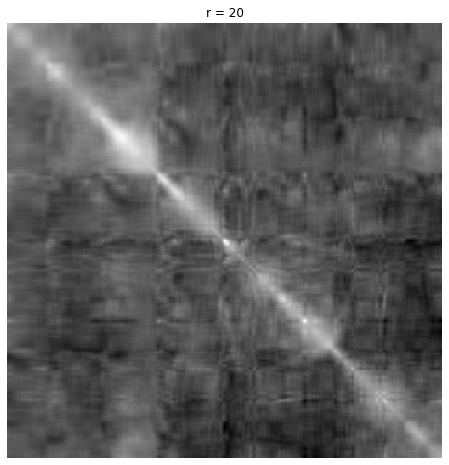

(512, 100)
(100, 100)
(100, 512)


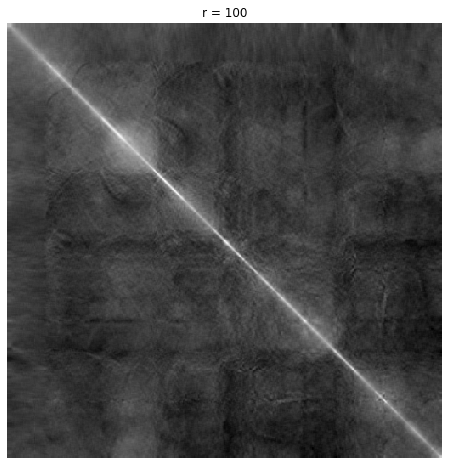

(512, 512)
(512, 512)
(512, 512)


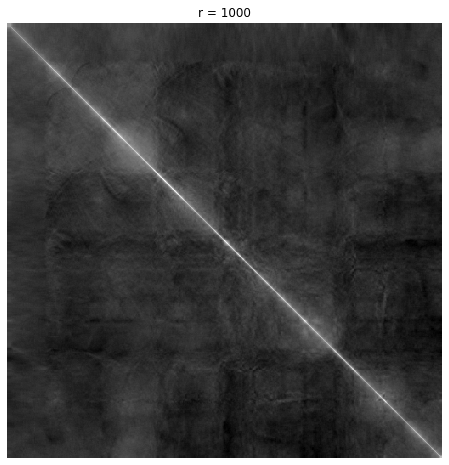

In [13]:
S, U, VT = svd_simultaneous_power_iteration(X,20)
S = np.diag(S)
print(U)
print(S)
print(VT)

j = 0
for r in (5, 20, 100, 1000):
    S, U, VT = svd_simultaneous_power_iteration(X, r)
    S = np.diag(S)
    print(U.shape)
    print(S.shape)
    print(VT.shape)
    Xapprox = U[:, :r] @ S[0:r, :r] @ VT[:r, :]
    plt.figure(j+1)
    j += 1
    img = plt.imshow(Xapprox)
    img.set_cmap('gray')
    plt.axis('off')
    plt.title('r = ' + str(r))
    plt.show()

In [5]:
S, U, VT = svd(X,20)
S = np.diag(S)
print(U)
print(S)
print(VT)

[[-0.04673372  0.02556467 -0.01452596 ...  0.02177535 -0.00133779
  -0.02155993]
 [-0.04673372  0.02556467 -0.01452596 ...  0.02177535 -0.00133779
  -0.02155993]
 [-0.04673372  0.02556467 -0.01452596 ...  0.02177535 -0.00133779
  -0.02155993]
 ...
 [-0.04191841  0.05016218  0.02140883 ...  0.04419708 -0.04948253
   0.05817024]
 [-0.04200818  0.04957101  0.01979122 ...  0.04306516 -0.05895973
   0.06288297]
 [-0.04200818  0.04957101  0.01979122 ...  0.04306516 -0.05895973
   0.06288297]]
[[261.12620584   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          36.7848349    0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0